In [1]:
import calibrimbore as cal 

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook

<IPython.core.display.Math object>

<IPython.core.display.Math object>

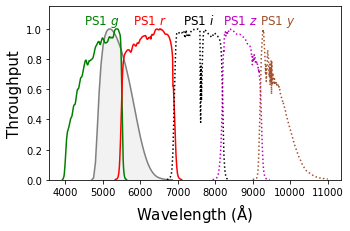

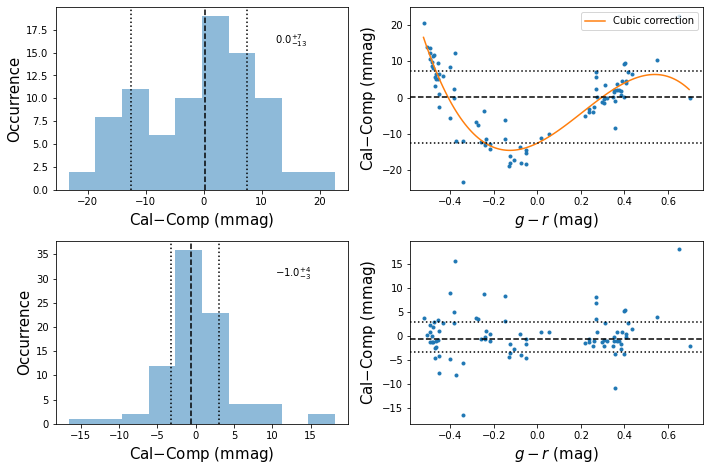

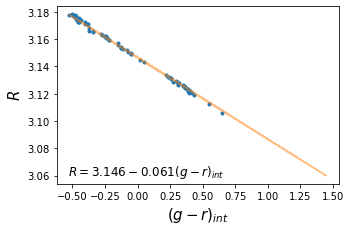

In [2]:
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/Kepler/Kepler_k.dat'
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/TESS/tess.dat'
filt = '/Users/rridden/Documents/work/code/source_synphot/source_synphot/passbands/keplercam/keplercam_V.dat'
ring = cal.sauron(band=filt,plot=True,system='ab',gr_lims=[-1,1.8],cubic_corr=True)

In [3]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyCoord, Angle
import pandas as pd

In [4]:
ra = 11
dec = 30
size = 600
Catalog = 'ps1'
c1 = SkyCoord(ra, dec, frame='icrs', unit='deg')
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
if Catalog == 'gaia':
    catalog = "I/345/gaia2"
elif Catalog == 'dist':
    catalog = "I/347/gaia2dis"
elif Catalog == 'ps1':
    catalog = "II/349/ps1"
elif Catalog == 'skymapper':
    catalog = 'II/358/smss'
else:
    raise ValueError("{} not recognised as a catalog. Available options: 'gaia', 'dist','ps1'")

result = Vizier.query_region(c1, catalog=[catalog],
                             radius=Angle(size, "arcsec"))
no_targets_found_message = ValueError('Either no sources were found in the query region '
                                      'or Vizier is unavailable')
#too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
if result is None:
    raise no_targets_found_message
elif len(result) == 0:
    raise no_targets_found_message
result = result[catalog].to_pandas()

In [5]:
test = ring.estimate_mag(ra=result.RAJ2000.values,dec=result.DEJ2000.values,catalog='vizier')

734534650
Querying regions with Vizier


/Users/rridden/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Querying regions with Vizier


In [6]:
test

array([21.73525002, 20.32704253,         nan, ..., 20.7249545 ,
       21.08731854, 21.24339794])

In [7]:
diff = result['rmag'].values-test[:1823]

In [8]:
np.nanmedian(diff)

-0.3506996001208478

(array([  6.,  31., 103.,  95., 101., 123., 219., 123.,  19.,   2.]),
 array([-1.09298173, -0.9611549 , -0.82932806, -0.69750122, -0.56567438,
        -0.43384754, -0.3020207 , -0.17019386, -0.03836703,  0.09345981,
         0.22528665]),
 <BarContainer object of 10 artists>)

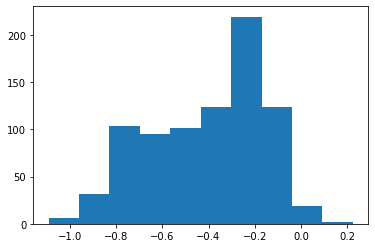

In [10]:
plt.figure()
plt.hist(diff)

In [13]:
b = np.array([1,2,2,2])
a = {'a':b,'b':b}

In [14]:
a['a'] = a['a'][b ==1]

In [15]:
a

{'a': array([1]), 'b': array([1, 2, 2, 2])}

In [3]:
ring.fit_cubic_correction()

In [4]:
ring.print_cubic_correction()

<IPython.core.display.Math object>

In [6]:
x = ring.ps1_mags['g'] - ring.ps1_mags['r']
xx = np.arange(min(x[ring.mask]),max(x[ring.mask]),0.01)
ring.make_spline(smoothing=1)

In [7]:
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [8]:
y = ring.diff[ring.mask]
X = x[ring.mask]
ind = np.argsort(X)

In [9]:
spl = CubicSpline(X[ind],y[ind])

In [10]:
def cubic(coeff,x):
    fit = coeff[0] + coeff[1] * x + coeff[2] * x**2 + coeff[3] * x**3
    return fit

def min_func(coeff,x,y):
    fit = cubic(coeff,x)
    chi = np.nansum((fit-y)**2)
    return abs(chi)

In [11]:
c0 = [10,10,10,10]
res = minimize(min_func,c0,args=(X,y))

In [12]:
res

      fun: 0.0009075554998217089
 hess_inv: array([[ 0.01639896, -0.010183  , -0.08369451,  0.06495123],
       [-0.010183  ,  0.17046898,  0.12528577, -0.5869    ],
       [-0.08369451,  0.12528577,  0.66240704, -0.63561701],
       [ 0.06495123, -0.5869    , -0.63561701,  2.72843678]])
      jac: array([ 4.44095349e-07, -2.52985046e-08,  6.33444870e-08, -7.42875272e-09])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([-0.00149431,  0.00014668,  0.01184363,  0.00173621])

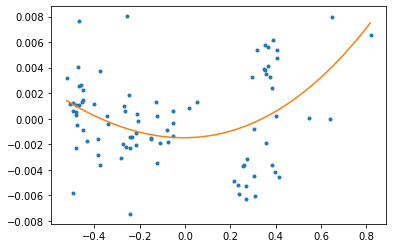

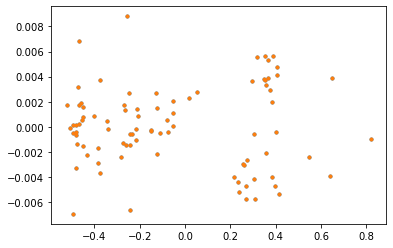

In [24]:
plt.figure()
plt.plot(x[ring.mask],ring.diff[ring.mask],'.')
plt.plot(xx,cubic(res.x,xx))


sub = ring.diff[ring.mask] - cubic(res.x,x[ring.mask])
plt.figure()
plt.plot(x[ring.mask],sub,'.')
m = ~cal.sigma_clip(sub,sigma=3).mask
plt.plot(x[ring.mask][m],sub[m],'.')

In [19]:
np.nanmedian(sub[m])

-0.00015122889501035825

In [20]:
np.nanstd(sub[m])

0.003211406339871656

In [21]:
np.nanstd(ring.diff[ring.mask][m])

0.0034759036155231474

Warning, 26 of 6260 bins contained negative fluxes; they have been set to zero.
Warning, 82 of 6560 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6560 bins contained negative fluxes; they have been set to zero.
Warning, 150 of 6876 bins contained negative fluxes; they have been set to zero.
Warning, 91 of 6558 bins contained negative fluxes; they have been set to zero.
Warning, 94 of 6875 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 6262 bins contained negative fluxes; they have been set to zero.
Warning, 30 of 1426 bins contained negative fluxes; they have been set to zero.
Warning, 27 of 1933 bins contained negative fluxes; they have been set to zero.
Warning, 10 of 6254 bins contained negative fluxes; they have been set to zero.
Warning, 1 of 6257 bins contained negative fluxes; they have been set to zero.
Warning, 22 of 6990 bins contained negative fluxes; they have been set to zero.
Warning, 3 of 4861 bins contained negativ

<IPython.core.display.Javascript object>


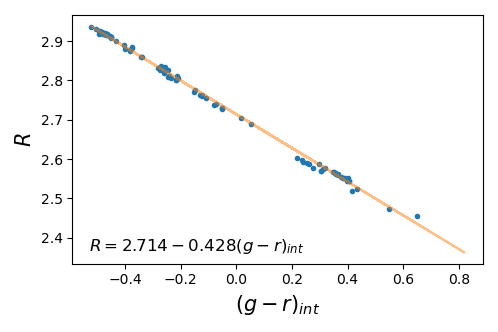

In [7]:
ring.calculate_R(plot=True)

In [ ]:
ring.

In [3]:
ring.fit_comp()

In [4]:
ring.coeff

array([ 0.        ,  0.23754716,  0.35333103,  0.27267768,  0.13748392,
       -0.00140542])

<IPython.core.display.Javascript object>


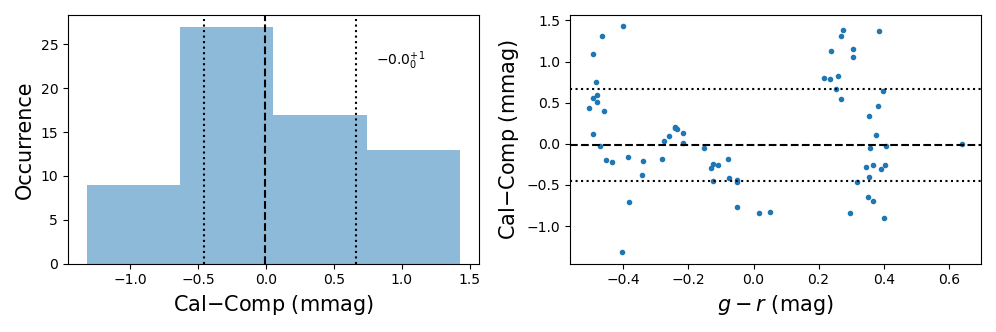

In [5]:
ring.diagnostic_plots()

In [6]:
ring.ps1_overlap

array([0.        , 0.1571635 , 0.27006522, 0.21300593, 0.06523388])

<IPython.core.display.Javascript object>


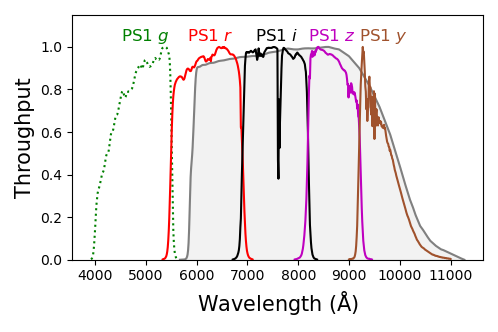

In [1]:
import astroquery
astroquery.__citation__

'@ARTICLE{2019AJ....157...98G,\n   author = {{Ginsburg}, A. and {Sip{\\H o}cz}, B.~M. and {Brasseur}, C.~E. and\n\t{Cowperthwaite}, P.~S. and {Craig}, M.~W. and {Deil}, C. and\n\t{Guillochon}, J. and {Guzman}, G. and {Liedtke}, S. and {Lian Lim}, P. and\n\t{Lockhart}, K.~E. and {Mommert}, M. and {Morris}, B.~M. and\n\t{Norman}, H. and {Parikh}, M. and {Persson}, M.~V. and {Robitaille}, T.~P. and\n\t{Segovia}, J.-C. and {Singer}, L.~P. and {Tollerud}, E.~J. and\n\t{de Val-Borro}, M. and {Valtchanov}, I. and {Woillez}, J. and\n\t{The Astroquery collaboration} and {a subset of the astropy collaboration}\n\t},\n    title = "{astroquery: An Astronomical Web-querying Package in Python}",\n  journal = {\\aj},\narchivePrefix = "arXiv",\n   eprint = {1901.04520},\n primaryClass = "astro-ph.IM",\n keywords = {astronomical databases: miscellaneous, virtual observatory tools},\n     year = 2019,\n    month = mar,\n   volume = 157,\n      eid = {98},\n    pages = {98},\n      doi = {10.3847/1538-38